<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/Staging/backwardTransaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/BScore

/content/drive/My Drive/Colab Notebooks/BScore


In [3]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.filterwarnings('ignore') #Disable warning

In [4]:
# Import data
transaction = pd.read_parquet(
    'Usedcar_transaction.parquet',
    engine = 'pyarrow'
)

# Data shape
print(f'Total rows: {transaction.shape[0]}\nTotal columns: {transaction.shape[1]}')

Total rows: 792456
Total columns: 31


In [5]:
# Create default flag
transaction['dfFlag'] = np.where(
    transaction['BUCKETS'].ge(4),
    1,
    0
)

In [6]:
# Create 12-Month default flag
transaction = transaction.sort_values(
    by = ['Br_Con', 'Monthkey']
) #Sort data by month
lag = 12 #12-Month performance window

for i in range(1, lag + 1):
  transaction[f'dfFlag{i}'] = transaction.groupby(
      ['Br_Con']
  )['dfFlag'].shift(-i).astype(np.float32)
  print(f'Column: {transaction.columns[-1]} created')

Column: dfFlag1 created
Column: dfFlag2 created
Column: dfFlag3 created
Column: dfFlag4 created
Column: dfFlag5 created
Column: dfFlag6 created
Column: dfFlag7 created
Column: dfFlag8 created
Column: dfFlag9 created
Column: dfFlag10 created
Column: dfFlag11 created
Column: dfFlag12 created


In [7]:
# Create ever 12-Month default flag
transaction['everDefault12'] = np.where(
    transaction.loc[:, 'dfFlag1':'dfFlag12'].max(axis = 1).eq(1),
    1,
    0
)

In [8]:
# Create backward transaction
for i in range(1, lag + 1):
  transaction[f'BUCKETS{i}'] = transaction.groupby(
      ['Br_Con']
  )['BUCKETS'].shift(i).astype(np.float32)
  print(f'Column: {transaction.columns[-1]} created')

Column: BUCKETS1 created
Column: BUCKETS2 created
Column: BUCKETS3 created
Column: BUCKETS4 created
Column: BUCKETS5 created
Column: BUCKETS6 created
Column: BUCKETS7 created
Column: BUCKETS8 created
Column: BUCKETS9 created
Column: BUCKETS10 created
Column: BUCKETS11 created
Column: BUCKETS12 created


### Staging trigger
The Bank shall measure the loss allowance equal to the lifetime expected credit losses for those financial instruments has increased significantly since initial recognition. However, there is no specific criteria mentioned in the standard.

Listed below is variables for Stage 2 trigger:

Trigger | Description 
-----------|------------
max_del_12 | Maximum delinquency in the last 12 months
max_del_9  | Maximum delinquency in the last 9 months
max_del_6  | Maximum delinquency in the last 6 months
max_del_3  | Maximum delinquency in the last 3 months
n_x_dpd_12 | Number of times that has delinquency more than 0 day (X DPD) in the last 12 months
n_30_dpd_12 | Number of times that has delinquency more than 30 day (30+ DPD) in the last 12 months
n_60_dpd_12 | Number of times that has delinquency more than 60 day (60+ DPD) in the last 12 months
n_90_dpd_12 | Number of times that has delinquency more than 90 day (90+ DPD) in the last 12 months
n_x_dpd_9 | Number of times that has delinquency more than 0 day (X DPD) in the last 9 months
n_30_dpd_9 | Number of times that has delinquency more than 30 day (30+ DPD) in the last 9 months
n_60_dpd_9 | Number of times that has delinquency more than 60 day (60+ DPD) in the last 9 months
n_90_dpd_9 | Number of times that has delinquency more than 90 day (90+ DPD) in the last 9 months
n_x_dpd_6 | Number of times that has delinquency more than 0 day (X DPD) in the last 6 months
n_30_dpd_6 | Number of times that has delinquency more than 30 day (30+ DPD) in the last 6 months
n_60_dpd_6 | Number of times that has delinquency more than 60 day (60+ DPD) in the last 6 months
n_90_dpd_6 | Number of times that has delinquency more than 90 day (90+ DPD) in the last 6 months
n_x_dpd_3 | Number of times that has delinquency more than 0 day (X DPD) in the last 3 months
n_30_dpd_3 | Number of times that has delinquency more than 30 day (30+ DPD) in the last 3 months
n_60_dpd_3 | Number of times that has delinquency more than 60 day (60+ DPD) in the last 3 months
n_90_dpd_3 | Number of times that has delinquency more than 90 day (90+ DPD) in the last 3 months
n_last_month_30 | Number of months since last in 30+ DPD
n_last_month_60 | Number of months since last in 60+ DPD
n_last_month_90 | Number of months since last in 90+ DPD

In [9]:
# Define iteration variables
monthRanges = [12, 9, 6, 3]
delRanges = [1, 2, 3, 4]
delLabels = ['x', '30', '60', '90']
triggers = [] #Keep staging triggers

# Maximum delinquency in last 12, 9, 6, 3 months
for i in monthRanges:
  transaction[f'max_del_{i}'] = transaction.loc[:, 'BUCKETS1':f'BUCKETS{i}'].max(axis = 1)
  print(f'Column: {transaction.columns[-1]} created')
  transaction[f'max_del_{i}'] = np.where(
      transaction[f'BUCKETS{i}'].isnull(),
      np.nan,
      transaction[f'max_del_{i}']
  ) #Replace unavailable data
  triggers.append([transaction.columns[-1], 'MAX_DEL'])

# Number of times that a contract has delinquency > 0 day (del >= 1) in last 12, 9, 6, 3 months
# Number of times that a contract has delinquency > 30 day (del >= 2) in last 12, 9, 6, 3 months
# Number of times that a contract has delinquency > 60 day (del >= 3) in last 12, 9, 6, 3 months
# Number of times that a contract has delinquency > 90 day (del >= 4) in last 12, 9, 6, 3 months
for i in monthRanges:
  for j, label in zip(delRanges, delLabels):
    transaction[f'n_{label}_dpd_{i}'] = transaction.loc[:, 'BUCKETS1':f'BUCKETS{i}'].ge(j).sum(axis = 1)
    print(f'Column: {transaction.columns[-1]} created')
    transaction[f'n_{label}_dpd_{i}'] = np.where(
        transaction[f'BUCKETS{i}'].isnull(),
        np.nan,
        transaction[f'n_{label}_dpd_{i}']
    ) #Replace unavailable data
    triggers.append([transaction.columns[-1], f'N_{label}_DPD'])

# Number of months since last delinquency as status equal to 30, 60, 90 days
for i, label in zip(delRanges[1:], delLabels[1:]): #(No x dpd)
  condition = transaction.loc[:, 'BUCKETS1':'BUCKETS12'].values == i
  transaction[f'n_last_month_{label}'] = np.where(
      np.any(
          condition,
          axis = 1
      ),
      condition.argmax(axis = 1) + 1,
      np.nan
  )
  print(f'Column: {transaction.columns[-1]} created')
  triggers.append([transaction.columns[-1], 'N_LAST_MONTH'])

Column: max_del_12 created
Column: max_del_9 created
Column: max_del_6 created
Column: max_del_3 created
Column: n_x_dpd_12 created
Column: n_30_dpd_12 created
Column: n_60_dpd_12 created
Column: n_90_dpd_12 created
Column: n_x_dpd_9 created
Column: n_30_dpd_9 created
Column: n_60_dpd_9 created
Column: n_90_dpd_9 created
Column: n_x_dpd_6 created
Column: n_30_dpd_6 created
Column: n_60_dpd_6 created
Column: n_90_dpd_6 created
Column: n_x_dpd_3 created
Column: n_30_dpd_3 created
Column: n_60_dpd_3 created
Column: n_90_dpd_3 created
Column: n_last_month_30 created
Column: n_last_month_60 created
Column: n_last_month_90 created


In [10]:
# Copy raw data to use later with staging result
transactionRAW = transaction.copy()

In [11]:
# Exclusion rules
# 1: Less than 12-months performance window
# 2: Bad at observation point (Defaulted transaction)

transaction = transaction.query(
    "Monthkey <= Monthkey.max() - 12 & dfFlag != 1"
)

# 3: Last transaction (No probability to observed)
transaction = transaction[transaction['dfFlag1'].notnull()]

# Data shape
print(f'Total rows: {transaction.shape[0]}\nTotal columns: {transaction.shape[1]}')

Total rows: 591428
Total columns: 80


In [12]:
# Summary table
triggerSummary = []

for trigger, types in triggers:
  summary = transaction.groupby(
      [trigger],
      as_index = False,
      dropna = False
  ).agg(
      {
          'everDefault12' : [
                             lambda x: x.sum(),
                             lambda x: x.count(),
                             lambda x: x.sum() / x.count()
          ]
      }
  )
  summary.columns = summary.columns.droplevel(1)
  summary.columns = ['Value', 'Bad', 'N', 'BadRate']
  summary = summary.reindex(
      ['Trigger', *summary.columns],
      axis = 1
  ).assign(
      Trigger = trigger
  ).assign(
      Types = types
  )
  triggerSummary.append(summary)

# To DataFrame
triggerSummary = pd.concat(
    triggerSummary,
    axis = 0,
    ignore_index = True
)
triggerSummary.head(5)

,Trigger,Value,Bad,N,BadRate,Types
0,max_del_12,0.0,508,178568,0.002845,MAX_DEL
1,max_del_12,1.0,2471,113139,0.021840,MAX_DEL
2,max_del_12,2.0,6681,54359,0.122905,MAX_DEL
3,max_del_12,3.0,3020,10138,0.297889,MAX_DEL
4,max_del_12,4.0,1205,2868,0.420153,MAX_DEL


In [13]:
# 30+ DPD as threshold for stage 2 trigger
threshold = (
    transaction.groupby(['BUCKETS'])['everDefault12'].sum() / \
    transaction.groupby(['BUCKETS'])['everDefault12'].count()
)

threshold

BUCKETS
0    0.012973
1    0.072037
2    0.250602
3    0.696702
Name: everDefault12, dtype: float64

In [14]:
# Extra first value of significant
triggerSelect = triggerSummary[
               triggerSummary['BadRate'] > threshold[2] #30+ DPD
].groupby(
    ['Trigger'],
    as_index = False,
    dropna = False
)['Value'].min()

triggerSelect = pd.merge(
    triggerSelect,
    triggerSummary[['Trigger', 'Value', 'BadRate', 'Types']],
    how = 'left',
    left_on = ['Trigger', 'Value'],
    right_on = ['Trigger', 'Value'],
)

triggerSelect

,Trigger,Value,BadRate,Types
0,max_del_12,3.0,0.297889,MAX_DEL
1,max_del_3,3.0,0.422144,MAX_DEL
2,max_del_6,3.0,0.369527,MAX_DEL
3,max_del_9,3.0,0.331609,MAX_DEL
4,n_30_dpd_12,7.0,0.262071,N_30_DPD
5,n_30_dpd_3,2.0,0.291779,N_30_DPD
6,n_30_dpd_6,3.0,0.257231,N_30_DPD
7,n_30_dpd_9,5.0,0.262483,N_30_DPD
8,n_60_dpd_12,1.0,0.284103,N_60_DPD
9,n_60_dpd_3,1.0,0.428712,N_60_DPD


In [15]:
# Extra lowest bad rate on each trigger type
triggerSelect['MinBadRate'] = triggerSelect.groupby(
    ['Types']
)['BadRate'].transform('min')

# Show result
triggerSelect[triggerSelect['MinBadRate'] == triggerSelect['BadRate']]

,Trigger,Value,BadRate,Types,MinBadRate
0,max_del_12,3.0,0.297889,MAX_DEL,0.297889
6,n_30_dpd_6,3.0,0.257231,N_30_DPD,0.257231
8,n_60_dpd_12,1.0,0.284103,N_60_DPD,0.284103
12,n_90_dpd_12,1.0,0.399758,N_90_DPD,0.399758
16,n_last_month_30,1.0,0.267152,N_LAST_MONTH,0.267152


In [16]:
# Selected triggers
'''
max_del_12 --> 3
n_30_dpd_6 --> 3
n_60_dpd_12 --> 1
n_90_dpd_12 --> 1
n_last_month_30 --> 1
'''

# Apply staging criteria with raw transaction
transactionRAW['Stage'] = np.where(
    transactionRAW['BUCKETS'].ge(4),
    3,
    np.where(
        (
            (transactionRAW['BUCKETS'].between(2, 3)) | \
            (transactionRAW['max_del_12'] == 3) | \
            (transactionRAW['n_30_dpd_6'] == 3) | \
            (transactionRAW['n_60_dpd_12'] == 1) | \
            (transactionRAW['n_90_dpd_12'] == 1) | \
            (transactionRAW['n_last_month_30'] == 1)
        ),
        2,
        1
    )
)

# Count summary
stageCount = transactionRAW.groupby(
    ['Monthkey', 'Stage'],
    as_index = False
)['Br_Con'].count().rename(
    columns = {'Br_Con': 'Count'}
)

In [17]:
# Create equal shape summary tabel
stageProtion = []
maxMonth = transactionRAW['Monthkey'].max()

for stage in range(1, 4):
  table = pd.DataFrame(
      range(1, maxMonth + 1),
      columns = ['Monthkey']
  ).assign(Stage = stage)
  stageProtion.append(table)

stageProtion = pd.concat(stageProtion, axis = 0)

# Mapping staging result
stageProtion = pd.merge(
    stageProtion,
    stageCount[['Monthkey', 'Stage', 'Count']],
    how = 'left',
    left_on = ['Monthkey', 'Stage'],
    right_on = ['Monthkey', 'Stage'],
).fillna(0).sort_values(
    by = ['Monthkey', 'Stage'],
    ignore_index = True
)

stageProtion.head(5)

,Monthkey,Stage,Count
0,1,1,565.0
1,1,2,0.0
2,1,3,0.0
3,2,1,1118.0
4,2,2,0.0


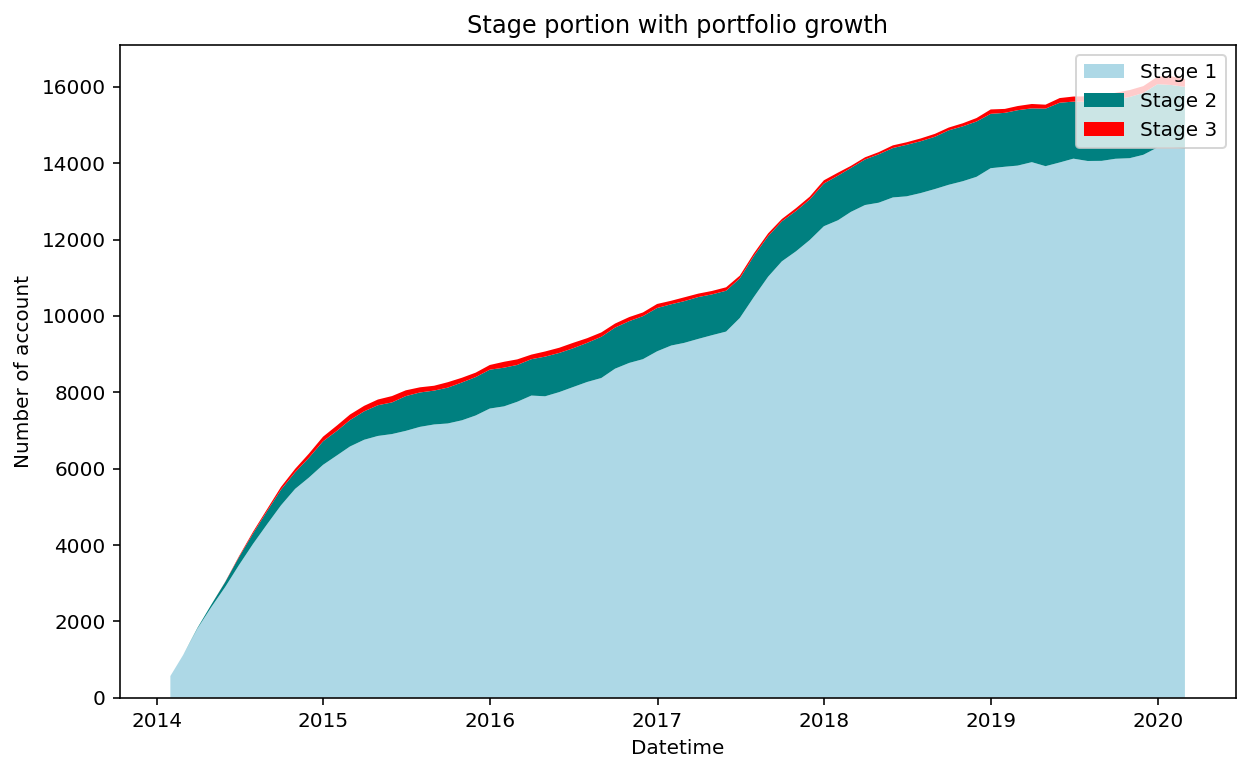

In [18]:
# Plot stage protion
stageAll = []

for i in range(1, 4):
  stage = np.array(stageProtion[stageProtion['Stage'] == i]['Count'])
  stageAll.append(stage)

stageAll = np.array(stageAll)

plt.figure(figsize = (10, 6))
plt.stackplot(
    pd.date_range(
        transactionRAW['AS_OF_DATE'].min(),
        transactionRAW['AS_OF_DATE'].max(),
        freq = 'M'
    ),
    stageAll[0],
    stageAll[1],
    stageAll[2],
    baseline = 'zero',
    colors = ['lightblue', 'teal', 'red'],
    labels = ['Stage 1', 'Stage 2', 'Stage 3']
)
plt.xlabel('Datetime')
plt.ylabel('Number of account')
plt.title('Stage portion with portfolio growth')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

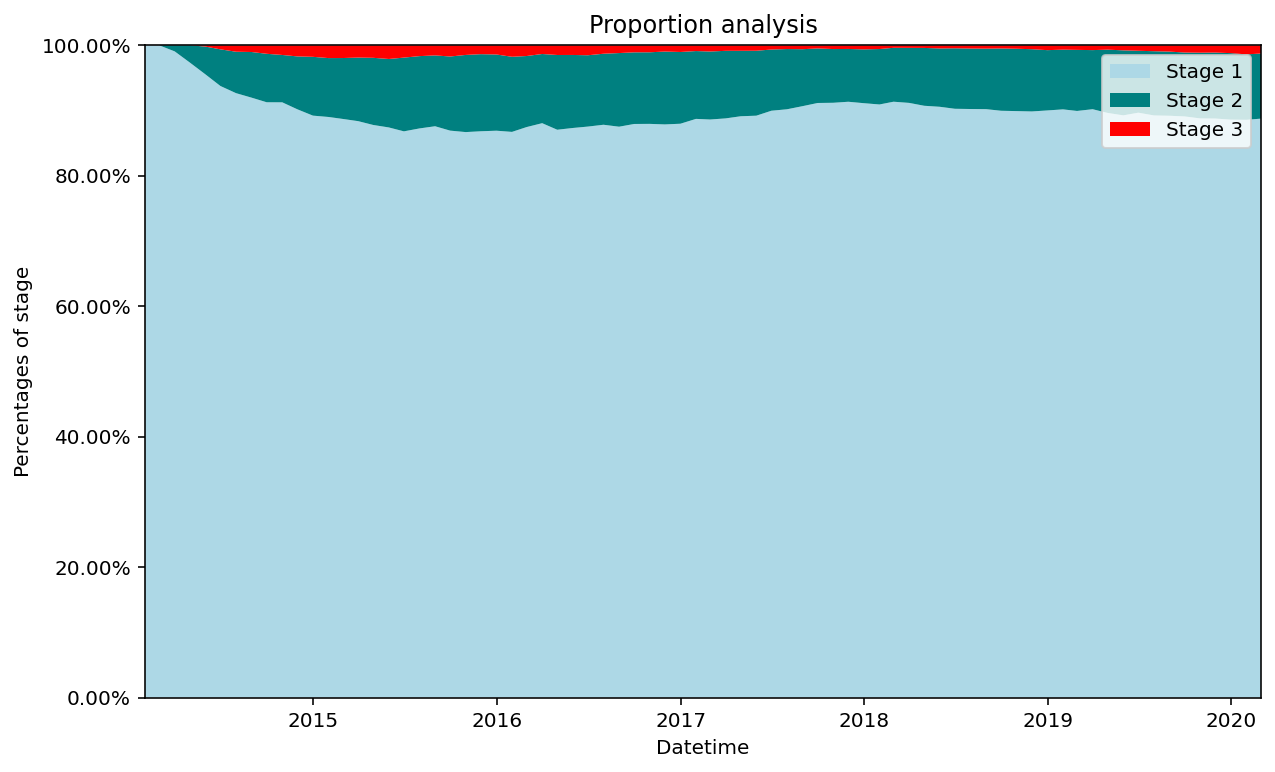

In [19]:
# Plot proportion analysis
plt.figure(figsize = (10, 6))
plt.stackplot(
    pd.date_range(
        transactionRAW['AS_OF_DATE'].min(),
        transactionRAW['AS_OF_DATE'].max(),
        freq = 'M'
    ),
    stageAll / stageAll.sum(axis = 0).astype(float) * 100,
    colors = ['lightblue', 'teal', 'red'],
    labels = ['Stage 1', 'Stage 2', 'Stage 3']
)
plt.gca().set_yticklabels([f'{y:.2f}%' for y in plt.gca().get_yticks()])
plt.margins(0, 0)
plt.xlabel('Datetime')
plt.ylabel('Percentages of stage')
plt.title('Proportion analysis')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

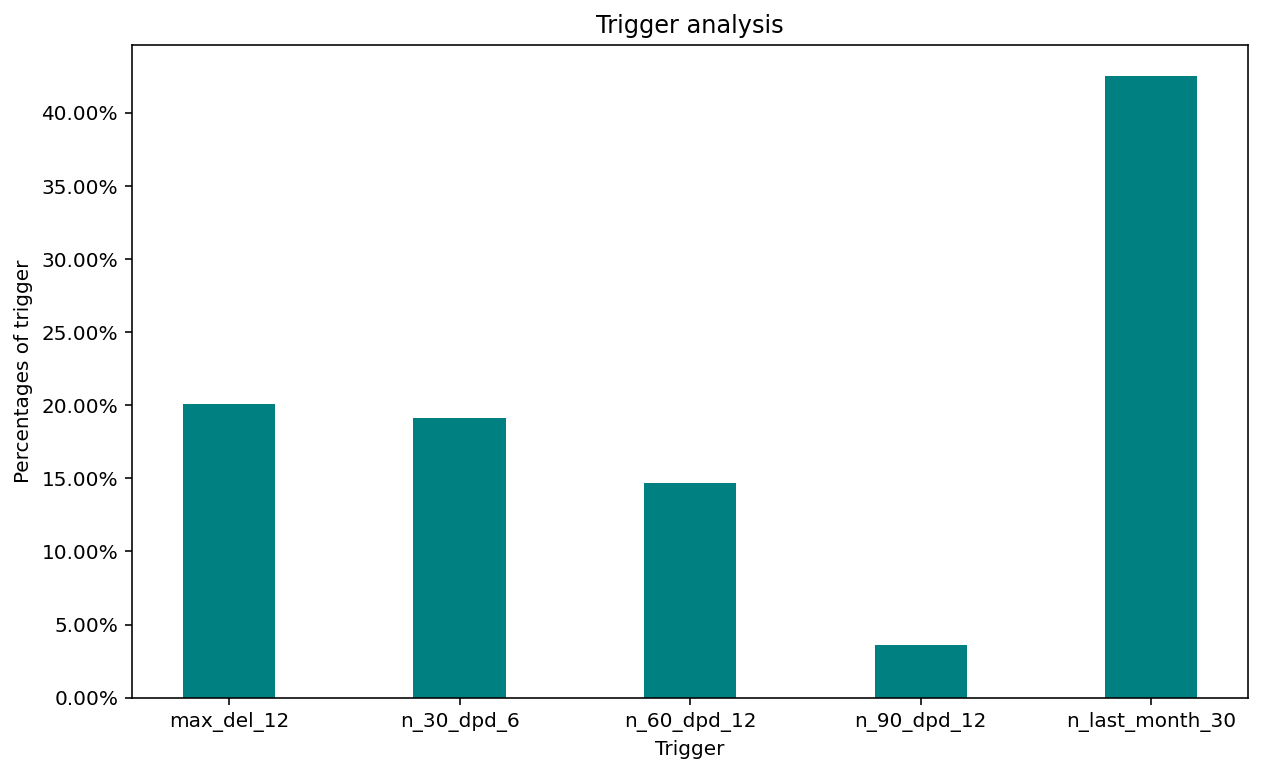

In [20]:
# Stage 2 Analysis
'''
max_del_12 --> 3
n_30_dpd_6 --> 3
n_60_dpd_12 --> 1
n_90_dpd_12 --> 1
n_last_month_30 --> 1
'''

stage2 = transactionRAW.query(
    "Stage == 2 & BUCKETS <= 1"
) #Only stage 2 without delinquency criteria

# Triggers condition
triggerValues = []

for trigger, j in zip(['max_del_12', 'n_30_dpd_6', 'n_60_dpd_12', 'n_90_dpd_12', 'n_last_month_30'], [3, 3, 1, 1, 1]):
  value = (stage2[trigger] == j).sum()
  triggerValues.append(value)

# Plot
plt.figure(figsize = (10, 6))
plt.bar(
    range(len(triggerValues)),
    triggerValues / sum(triggerValues),
    width = 0.4,
    color = 'teal'
)
plt.xticks(
    range(len(triggerValues)),
    ['max_del_12', 'n_30_dpd_6', 'n_60_dpd_12', 'n_90_dpd_12', 'n_last_month_30']
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.xlabel('Trigger')
plt.ylabel('Percentages of trigger')
plt.title('Trigger analysis')
plt.show()